In [2]:
# %cd turnus
%load_ext autoreload
%autoreload 2

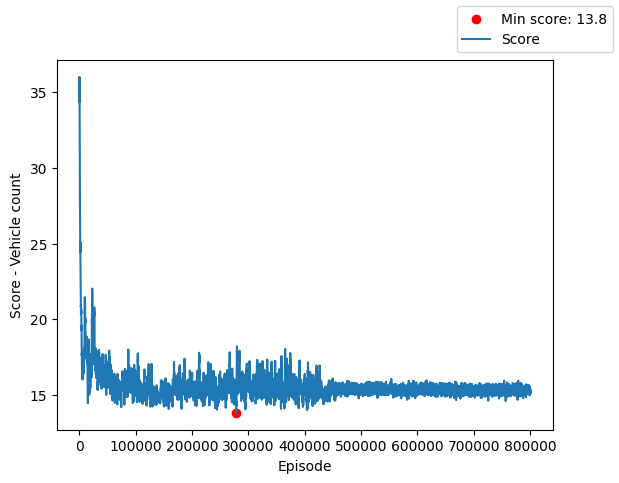

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

training = '240315#p_rand_110_dmodel'
df = pd.read_csv(f'results/{training}/score.csv')
df2 = pd.read_csv(f'results/{training}/loss.csv')
fig, ax1 = plt.subplots()

best_score, index = np.min(df['avg_score']), np.argmin(df['avg_score'])

ax1.scatter(df['episode'][index], best_score, c='red', label=f"Min score: {round(best_score, 1)}")
ax1.plot(df['episode'], df['avg_score'], label='Score')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Score - Vehicle count')

# ax1.axhline(y=4, color='r', linestyle='--', label='Target score')
# ax1.text(0, 4.5, 'Target score', color='red', fontsize=8)

# ax2 = ax1.twinx()
ax2.plot(df2['iteration'], df2['ext_value'], c='green', label='Extrinsic value loss')
ax2.plot(df2['episode'], df2['int_value'], c='orange', label='Intrinsic value loss')
fig.legend()

In [6]:
import time
import torch
from env import Env
import utils.graph_utils as graph_utils
from model import GCNPolicy
from utils.utils import reward_to_obj
from torch_geometric.data import Data
import torch.nn.functional as F

def e_greedy_eval(net: torch.nn.Module, env: Env):
    observation, mask = env.reset()
    terminal = False

    r_sum = 0
    while not terminal:
        logit, ext_value, int_value = net(observation)
        logit = torch.where(mask, logit, torch.tensor(-1e+8, device=logit.device))
        probs = F.softmax(logit, dim=-1)
        action = probs.argmax()
        observation, mask, reward, terminal, _ = env.step(action.item())
        r_sum += reward

    transform_rewards = env.reward_to_score_transformer()

    return observation, r_sum, env.vehicleID - 1

def search_results(net: torch.nn.Module, env: Env, search_count = 100):
    result_observations = []
    result_rewards = []
    for i in range(search_count):
        observation, mask = env.reset()
        terminal = False

        r_sum = 0
        while not terminal:
            logit, ext_value, int_value = net(observation)
            logit = torch.where(mask, logit, torch.tensor(-1e+8, device=device))
            probs = F.softmax(logit, dim = -1)
            action = probs.multinomial(num_samples = 1)
            observation, mask, reward, terminal, _ = env.step(action.item())
            r_sum += reward

        result_observations.append(observation)
        result_rewards.append(r_sum)

    transform_rewards = env.reward_to_score_transformer()

    return result_observations, result_rewards, list(map(transform_rewards, result_rewards))

# def eval_search_results(observations, rewards, env: Env):

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nodes = []
times = []
for i in range(1, 11):
    graph, optimal = graph_utils.load_problem(f'data/{i}')

    env = Env(graph = graph, optimal = optimal, device=device)
    net = GCNPolicy(env.state_space(), env.action_space()).to(device)
    # net.load_state_dict(torch.load('results/240206#p_2_gcn_continue/models/iter_6.pt'))
    net.load_state_dict(torch.load('results/240315#p_rand_110_dmodel/models/iter_2648.pt', map_location=device))
    net.eval()

    start = time.time()
    observation, _, vehicles = e_greedy_eval(net, env)
    # observations, rewards, vehicles = search_results(net, env, 100)
    took = round(time.time() - start, 2)
    times.append(took)
    nodes.append(graph.num_nodes)
    print(f'Problem {i} ({graph.num_nodes} nodes); \t agent: {vehicles} (opt. {optimal}) - it took {took}s')

Problem 1 (51 nodes); 	 agent: 4 (opt. 4) - it took 4.73s
Problem 2 (79 nodes); 	 agent: 4 (opt. 4) - it took 7.11s
Problem 3 (85 nodes); 	 agent: 5 (opt. 5) - it took 7.75s
Problem 4 (107 nodes); 	 agent: 6 (opt. 6) - it took 10.15s
Problem 5 (135 nodes); 	 agent: 9 (opt. 8) - it took 12.82s
Problem 6 (162 nodes); 	 agent: 10 (opt. 9) - it took 17.06s
Problem 7 (247 nodes); 	 agent: 13 (opt. 13) - it took 24.77s
Problem 8 (417 nodes); 	 agent: 26 (opt. 26) - it took 43.48s
Problem 9 (496 nodes); 	 agent: 28 (opt. 28) - it took 49.06s
Problem 10 (929 nodes); 	 agent: 51 (opt. 49) - it took 109.33s


Text(0, 0.5, 'Time [s]')

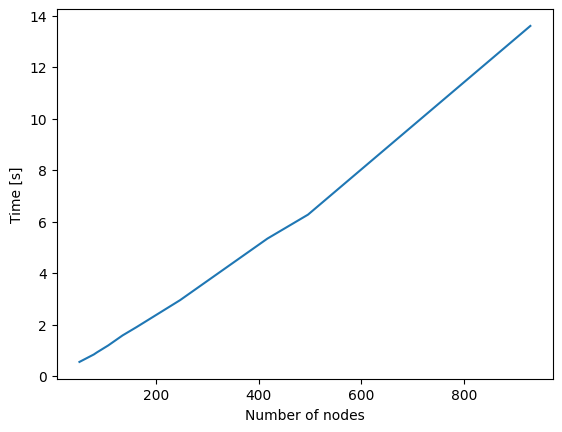

In [8]:
import matplotlib.pyplot as plt

plt.plot(nodes, times)
plt.xlabel('Number of nodes')
plt.ylabel('Time [s]')

In [2]:
def get_tours_by_vehicles(graph: Data, env: Env):
    vehicles = {}
    for i in range(graph.num_nodes):
        node = graph.x[i]
        vehicle = (node[env.flag_visited_index] * env.MAX_VEHICLES).round(decimals=5).item()

        if vehicle != int(vehicle):
            raise ValueError(f"Vehicle ID is not an integer. Got {vehicle} for {i}")

        vehicle = int(vehicle)

        if str(vehicle) not in vehicles:
            vehicles[str(vehicle)] = []

        vehicles[str(vehicle)].append(i)

    return vehicles

get_tours_by_vehicles(observation.cpu(), env)

{'0': [0, 246],
 '9': [1, 16, 29, 42, 57, 130, 142, 153, 161, 168],
 '12': [2, 15, 31, 43, 55],
 '13': [3, 17, 32, 44, 56, 66],
 '5': [4,
  18,
  25,
  36,
  49,
  61,
  68,
  73,
  78,
  88,
  93,
  98,
  101,
  110,
  116,
  122,
  126,
  138,
  144,
  154,
  163,
  172,
  176,
  181,
  192,
  204,
  214,
  222],
 '2': [5,
  19,
  27,
  38,
  50,
  62,
  70,
  76,
  81,
  85,
  91,
  95,
  99,
  105,
  107,
  117,
  125,
  129,
  134,
  145,
  157,
  169,
  177,
  180,
  184,
  187,
  194,
  198,
  206,
  210,
  217,
  223,
  226,
  232,
  235,
  237,
  242],
 '6': [6,
  13,
  28,
  40,
  51,
  58,
  69,
  77,
  82,
  111,
  118,
  128,
  136,
  143,
  151,
  159,
  170,
  179,
  195,
  200],
 '11': [7, 26, 41, 54, 65, 149],
 '10': [8, 21, 34, 48, 63, 140, 152, 164],
 '1': [9,
  23,
  37,
  53,
  67,
  74,
  80,
  84,
  87,
  90,
  96,
  102,
  106,
  114,
  119,
  131,
  141,
  155,
  165,
  175,
  185,
  188,
  193,
  201,
  207,
  211,
  216,
  219,
  225,
  229,
  233,
  236,
  2

In [3]:
def get_result_subgraph(graph: Data, env: Env):
    vehicle_tours = get_tours_by_vehicles(graph, env)
    start_depo, end_depo = vehicle_tours['0']
    edges = []
    for vehicle, node_ids in vehicle_tours.items():
        if vehicle == '0':
            continue
        
        if len(node_ids) > 0:
            edges.append([start_depo, node_ids[0]])

        for i in range(len(node_ids) - 1):
            edges.append([node_ids[i], node_ids[i+1]])

        if len(node_ids) > 0:
            edges.append([node_ids[-1], end_depo])

    edges = torch.tensor(edges)

    return Data(x=graph.x, edge_index=edges.t().contiguous())

get_result_subgraph(observation.cpu(), env)

Data(x=[247, 8], edge_index=[2, 258])

In [19]:
gr = get_result_subgraph(observation.cpu(), env)
edges = gr.edge_index.t()

edges[edges[:, 0] == 92]

tensor([[ 92, 209]])

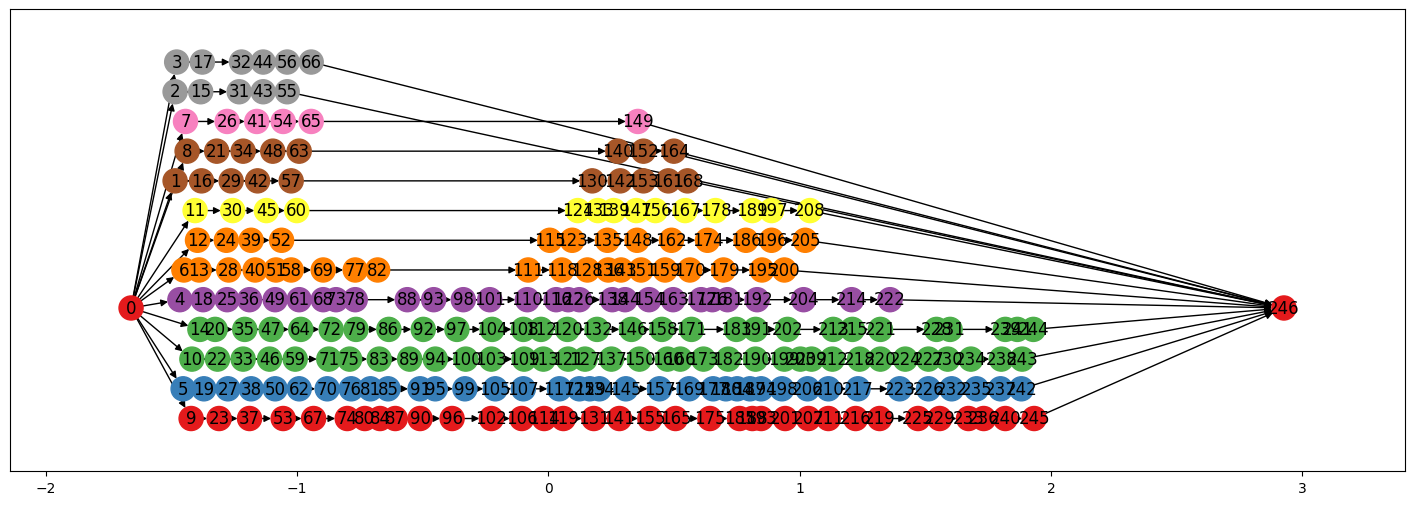

In [4]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import numpy as np

def draw_graph_by_vehicles(graph: Data, env: Env):
    node_labels = graph.x[:, env.flag_visited_index].numpy()
    positions = {}

    center = np.mean(node_labels)

    for i in range(graph.num_nodes):
        node = graph.x[i]
        if node[env.flag_visited_index] == 0:
            positions[i] = [node[2], center]
        else:
            positions[i] = [node[2], node[env.flag_visited_index]]

    g = to_networkx(graph)

    fig, ax = plt.subplots(1, 1, figsize=(18,6))
    nx.draw(g, pos=positions, cmap=plt.get_cmap('Set1'), node_color=node_labels, with_labels=True, ax=ax)
    limits=plt.axis('on')
    ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)

# observation, _, vehicles = e_greedy_eval(net, env)
draw_graph_by_vehicles(get_result_subgraph(observation.cpu(), env), env)

In [5]:
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer

data = observation.cpu() # A homogeneous graph data object.

net = GCNPolicy(env.state_space(), env.action_space()).to(device)
net.load_state_dict(torch.load('results/240315#p_rand_110_dmodel/models/iter_2648.pt', map_location=device))
net.eval()

explainer = Explainer(
    model=net,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',  # Model returns log probabilities.
    ),
)

explanation = explainer(data, data.edge_index, index=10)
print(explanation.edge_mask)
print(explanation.node_mask)

AttributeError: 'GlobalStorage' object has no attribute 'dtype'

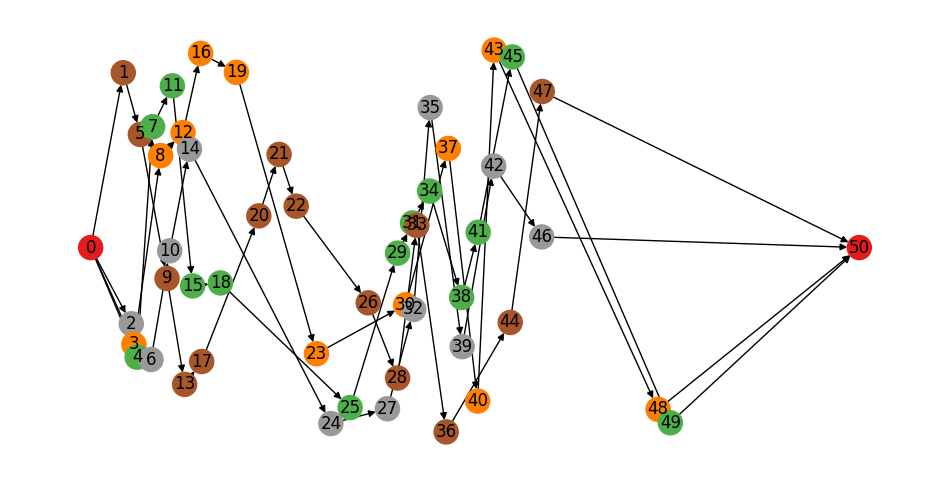

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def draw_graph(graph: Data, env: Env, info=""):
    node_labels = graph.x[:, env.flag_visited_index].numpy()
    positions = {}

    gen = np.random.default_rng(graph.num_nodes)

    mean = graph.x[:, 2].mean()

    for i in range(graph.num_nodes):
        node = graph.x[i]
        if i == 0 or i == graph.num_nodes - 1:
            positions[i] = [node[2].item(), mean]
        else:
            positions[i] = [node[2].item(), mean + (gen.random() - 0.5)]

    g = to_networkx(graph)

    pos = nx.layout.spring_layout(g, pos= positions)
    plt.figure(1,figsize=(12,6))
    plt.text(1, 1, info) 
    nx.draw(g, pos=positions, cmap=plt.get_cmap('Set1'), node_color=node_labels, with_labels=True)

def draw_result(model: str, env: Env):
    observation, _, vehicles = e_greedy_eval(model, env)
    draw_graph(get_result_subgraph(observation.cpu(), env), env, f"Vehicles: {vehicles}")

draw_graph(get_result_subgraph(observation.cpu(), env), env)

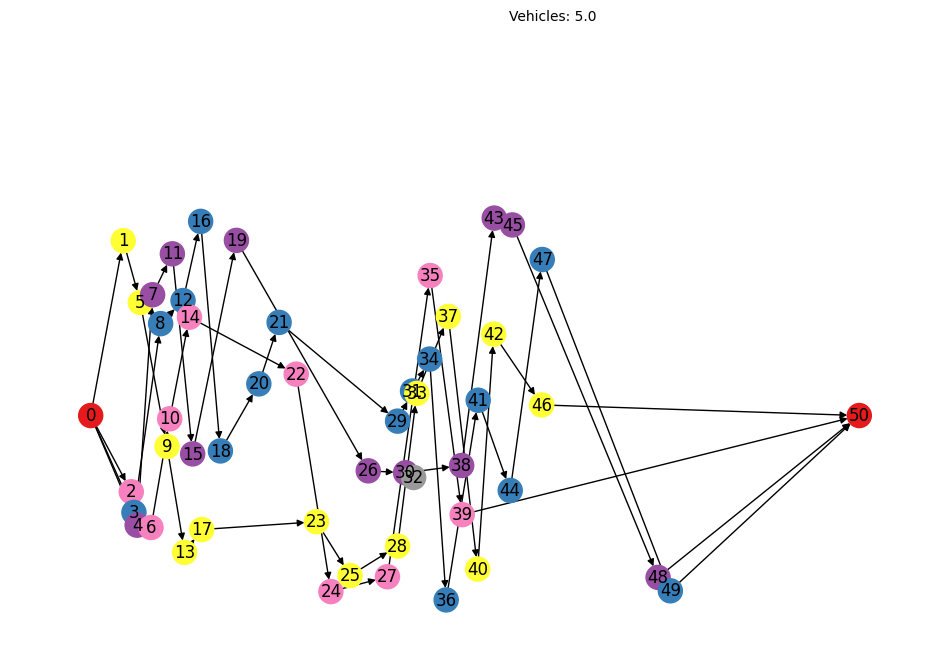

In [14]:
draw_result('results/models/ppo_1021_ppo.pt', env)